# Определение возраста покупателей

## Исследовательский анализ данных

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

# Исследовательский анализ данных

In [4]:
path = '/datasets/faces/'

In [5]:
df = pd.read_csv(path + 'labels.csv')

In [6]:
display(df.head())
print(df.shape)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)


Смотрим несколько фотографий

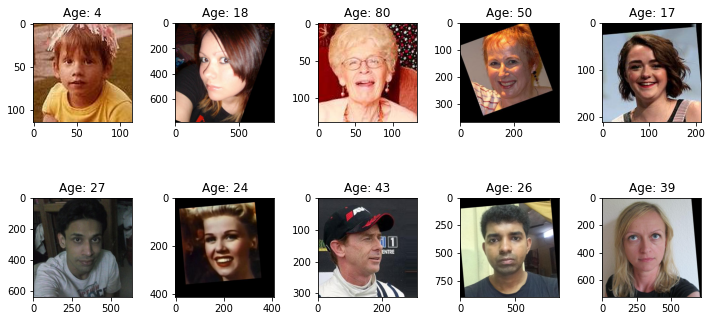

In [7]:
fig = plt.figure(figsize=(10,5), tight_layout=True)
#fig.tight_layout()

for i in range(10):
    plt.subplot(2,5,i+1, title = 'Age: ' + str(df['real_age'][i]))
    img = plt.imread(path + 'final_files/' + df['file_name'][i])
    plt.imshow(img)

Смотрим распределение возрастов

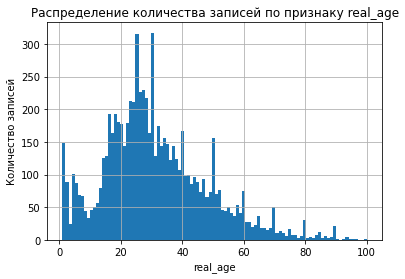

In [8]:
df['real_age'].hist(bins = df['real_age'].max())
plt.xlabel('real_age')
plt.ylabel('Количество записей')
plt.title('Распределение количества записей по признаку real_age' ) 
plt.show() 

Изучим выбросы

In [10]:
print(df['real_age'].value_counts().sort_index(ascending=True))

1      149
2       88
3       25
4      101
5       87
      ... 
94       5
95       2
96       2
97       1
100      1
Name: real_age, Length: 97, dtype: int64


Посмотрим, похожи ли дети на фото на однолетних

In [11]:
df_search = df.query('real_age == 1').reset_index()
display(df_search.head())

,index,file_name,real_age
0,13,000013.jpg,1
1,21,000021.jpg,1
2,30,000030.jpg,1
3,40,000040.jpg,1
4,53,000053.jpg,1


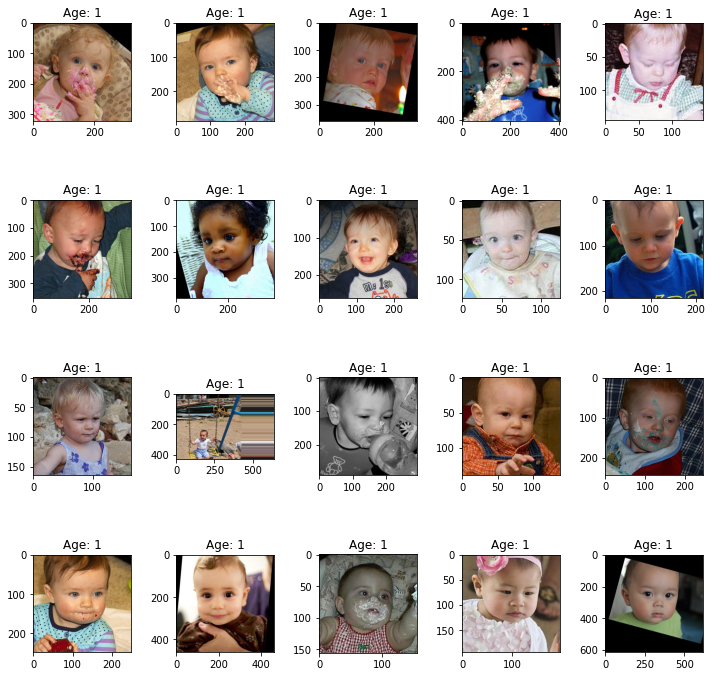

In [12]:
fig = plt.figure(figsize=(10,10), tight_layout=True)
for i in range(20):
    plt.subplot(4,5,i+1, title = 'Age: ' + str(df_search['real_age'][i]))
    img = plt.imread(path + 'final_files/' + df_search['file_name'][i])
    plt.imshow(img)

In [13]:
print(df.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [15]:
for i in range(10):
    img = plt.imread(path + 'final_files/' + df['file_name'][i])
    print('Размеры изображения ', i, ':', img.shape)


Размеры изображения  0 : (114, 114, 3)
Размеры изображения  1 : (784, 784, 3)
Размеры изображения  2 : (133, 133, 3)
Размеры изображения  3 : (370, 370, 3)
Размеры изображения  4 : (212, 212, 3)
Размеры изображения  5 : (636, 637, 3)
Размеры изображения  6 : (412, 412, 3)
Размеры изображения  7 : (311, 311, 3)
Размеры изображения  8 : (898, 897, 3)
Размеры изображения  9 : (724, 724, 3)


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >



from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
    Flatten,
    BatchNormalization,
    Dropout,
    GlobalAveragePooling2D,
    GlobalMaxPool2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

import numpy as np
import pandas as pd




def load_train(path):
    
    batch_size = 16
    
    df = pd.read_csv(path + 'labels.csv')
    #df['real_age'] = df['real_age'].astype(str)
    path =  path + 'final_files/'
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        )
    
    train_datagen_flow = datagen.flow_from_dataframe(
        #dataframe=df[:100],
        dataframe=df,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training'
        )
    return train_datagen_flow




def load_test(path):
    
    batch_size = 16
    
    df = pd.read_csv(path + 'labels.csv')
    #df['real_age'] = df['real_age'].astype(str)
    path =  path + 'final_files/'
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        )
    
    val_datagen_flow = datagen.flow_from_dataframe(
        #dataframe=df[:100],
        dataframe=df,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='validation'
        )

    return val_datagen_flow




def create_model(input_shape):
    optimizer = Nadam(learning_rate=0.0002)
    #optimizer = Nadam()
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    #backbone.trainable = False #
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model




def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs = 10, 
    steps_per_epoch = None,
    validation_steps = None
):
    
    #steps_per_epoch=len(train_data),
    #validation_steps=len(test_data)
    
    model.fit(train_data,
          validation_data=test_data,
          batch_size = batch_size,  
          epochs = epochs,              
          steps_per_epoch=steps_per_epoch, 
          validation_steps=validation_steps, 
          verbose=2  
         ) 


    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >



2024-11-20 15:05:09.802899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-11-20 15:05:09.869232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-11-20 15:05:15.529383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-11-20 15:05:16.438365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-11-20 15:05:16.438429: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 15:05:16.438469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-11-20 15:05:16.519979: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-11-20 15:05:16.532625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-11-20 15:05:16.672015: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-11-20 15:05:16.685700: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-11-20 15:05:16.685802: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-11-20 15:05:16.689846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-11-20 15:05:17.289329: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-11-20 15:05:17.345485: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2024-11-20 15:05:17.348111: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d38140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-11-20 15:05:17.348163: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-11-20 15:05:17.517498: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x604c750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-20 15:05:17.517537: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-11-20 15:05:17.519748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-11-20 15:05:17.519831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 15:05:17.519846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-11-20 15:05:17.519886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-11-20 15:05:17.519904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-11-20 15:05:17.519918: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-11-20 15:05:17.519932: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-11-20 15:05:17.519944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-11-20 15:05:17.524191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-11-20 15:05:17.525625: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-11-20 15:05:19.211794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-11-20 15:05:19.211836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-11-20 15:05:19.211849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-11-20 15:05:19.216049: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-20 15:05:19.216122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


178/178 - 42s - loss: 47.6210 - mae: 5.2334 - val_loss: 315.7965 - val_mae: 13.2176
Epoch 4/10
178/178 - 43s - loss: 33.2860 - mae: 4.3488 - val_loss: 149.1635 - val_mae: 9.2558
Epoch 5/10
178/178 - 42s - loss: 25.9579 - mae: 3.8149 - val_loss: 95.6030 - val_mae: 7.3407
Epoch 6/10
178/178 - 42s - loss: 21.6260 - mae: 3.4889 - val_loss: 84.9127 - val_mae: 7.0696
Epoch 7/10
178/178 - 42s - loss: 18.4367 - mae: 3.2478 - val_loss: 75.7691 - val_mae: 6.4363
Epoch 8/10
178/178 - 42s - loss: 15.0798 - mae: 2.9517 - val_loss: 70.1727 - val_mae: 6.2911
Epoch 9/10
178/178 - 42s - loss: 13.8831 - mae: 2.8177 - val_loss: 79.9371 - val_mae: 6.8171
Epoch 10/10
178/178 - 42s - loss: 13.0746 - mae: 2.7072 - val_loss: 75.9496 - val_mae: 6.5862

```

## Анализ обученной модели

Напишите выводы здесь

<div class="alert alert-info"> 
Вывод  

Модель предсказывает возраст по фотографии со средней точностью около +- 6 с половиной лет

</div>